In [4]:
%matplotlib inline
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
sns.set(style="ticks")

In [5]:
nyc_cab_df = pd.read_csv('data/nyc_car_hire_data.csv', low_memory=False)

In [6]:
def train_test_split(df, n_samples, validation=False):
    if validation:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        non_test = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]
        
        msk = np.random.rand(len(non_test)) < 0.7
        train = non_test[msk]
        validation = non_test[~msk]
        
        return train, validation, test
    
    else:
        nyc_cab_sample = df.sample(n=n_samples)

        nyc_cab_sample['lpep_pickup_datetime'] = nyc_cab_sample['lpep_pickup_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)
        nyc_cab_sample['Lpep_dropoff_datetime'] = nyc_cab_sample['Lpep_dropoff_datetime'].apply(lambda dt: pd.to_datetime(dt).hour)

        msk = np.random.rand(len(nyc_cab_sample)) < 0.8
        train = nyc_cab_sample[msk]
        test = nyc_cab_sample[~msk]

        return train, test

---

## Dimensionality Reduction: PCA

In [7]:
train, validation, test = train_test_split(nyc_cab_df, 1000, validation=True)

y_train = train['Fare_amount'].values
y_val = validation['Fare_amount'].values
y_test = test['Fare_amount'].values

regression_model = LinearRegression(fit_intercept=True)

all_predictors = ['Trip Length (min)', 'Type', 'Trip_distance', 'TMAX', 'TMIN', 'lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Pickup_longitude', 'Pickup_latitude', 'SNOW', 'SNWD', 'PRCP']

train.describe()

,AWND,Day,Dropoff_latitude,Dropoff_longitude,Ehail_fee,Extra,Fare_amount,Lpep_dropoff_datetime,MTA_tax,PRCP,...,TMIN,Tip_amount,Tolls_amount,Total_amount,Trip_distance,Trip_type,Type,VendorID,lpep_pickup_datetime,Trip Length (min)
count,535.000000,535.000000,378.000000,378.000000,0.0,378.000000,535.000000,535.000000,378.000000,535.000000,...,535.000000,378.000000,378.000000,378.000000,535.000000,361.000000,535.000000,378.000000,535.000000,535.000000
mean,6.283738,15.517757,40.759738,-73.935685,NaN,0.350529,14.565847,14.351402,0.480159,0.310860,...,43.179439,1.023228,0.042302,14.047011,2.863370,1.038781,0.293458,1.761905,14.465421,11.242991
std,1.762111,8.810275,0.058366,0.048911,NaN,0.376022,8.486821,6.284744,0.097736,0.996113,...,6.098562,1.827929,0.473573,9.340605,2.349498,0.193341,0.455773,0.426482,6.143281,7.737066
min,2.000000,1.000000,40.579613,-74.030663,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,31.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
25%,4.900000,7.000000,40.714279,-73.967245,NaN,0.000000,7.500000,10.000000,0.500000,0.000000,...,40.000000,0.000000,0.000000,8.000000,1.335000,1.000000,0.000000,2.000000,10.500000,6.000000
50%,5.800000,16.000000,40.756475,-73.949051,NaN,0.500000,12.500000,16.000000,0.500000,0.000000,...,43.000000,0.000000,0.000000,11.000000,2.222639,1.000000,0.000000,2.000000,16.000000,10.000000
75%,8.300000,23.000000,40.806599,-73.910969,NaN,0.500000,21.270310,19.000000,0.500000,0.070000,...,46.000000,1.687500,0.000000,17.000000,3.473593,1.000000,1.000000,2.000000,19.000000,14.000000
max,9.400000,30.000000,40.947834,-73.736076,NaN,1.000000,51.500000,23.000000,0.500000,4.970000,...,59.000000,11.450000,5.330000,68.780000,18.600000,2.000000,1.000000,2.000000,23.000000,54.000000


How deal with missing values? Can try to impute them. Or can try to make new flag variable that shows whether a value was missing or not. This issue will be dealt w/later on in the course.

### 1. Variable Selection: Backwards

Use backwards if not too many predictors, because start w/full set.

In [8]:
def get_aic(X_train, y_train):
    X_train = add_constant(X_train)
    model = sm.OLS(y_train, X_train).fit()
    return model.aic

X_train = train[all_predictors].values
predictors = [(all_predictors, get_aic(X_train, y_train))]

for k in range(len(all_predictors), 1, -1):
    best_k_predictors = predictors[-1][0]
    aics = []
    
    for predictor in best_k_predictors:
        k_minus_1 = list(set(best_k_predictors) - set([predictor]))
        X_train = train[k_minus_1].values

        aics.append(get_aic(X_train, y_train))
    
    best_k_minus_1 = list(set(best_k_predictors) - set([best_k_predictors[np.argmin(aics)]]))
    predictors.append((best_k_minus_1, np.min(aics)))
    
best_predictor_set = sorted(predictors, key=lambda t: t[1])[-1]

In [9]:
best_predictor_set = sorted(predictors, key=lambda t: t[1])[0]

X_train = train[best_predictor_set[0]].values
X_val = validation[best_predictor_set[0]].values  
X_test = test[best_predictor_set[0]].values  
regression_model.fit(np.vstack((X_train, X_val)), np.hstack((y_train, y_val)))

print('best predictor set: {}\ntest R^2: {}'.format(best_predictor_set[0], regression_model.score(X_test, y_test)))

best predictor set: ['Type', 'SNWD', 'Pickup_latitude', 'Trip_distance', 'SNOW', 'Trip Length (min)']
test R^2: 0.8862871835970846


## 2. Variable Selection: LASSO Regression

In [10]:
X_train = train[all_predictors].values
X_val = validation[all_predictors].values
X_non_test = np.vstack((X_train, X_val))
X_test = test[all_predictors].values

y_non_test = np.hstack((y_train, y_val))

lasso_regression = Lasso(alpha=1.0, fit_intercept=True) # big alpha means big lambda. just arbitrarily chose 1.0 as test case. should really do cross-validation
lasso_regression.fit(X_non_test, y_non_test)

print('Lasso regression model:\n {} + {}^T . x'.format(lasso_regression.intercept_, lasso_regression.coef_))

Lasso regression model:
 4.5454073919828755 + [ 0.29479264  4.0125848   1.94653749 -0.00639226 -0.          0.
  0.02101688 -0.         -0.          0.          0.          0.        ]^T . x


In [11]:
print('Test R^2: {}'.format(lasso_regression.score(X_test, y_test)))

Test R^2: 0.8018807782334032


### 3. Principal Component Regression

In [12]:
pca = PCA(n_components=4)
pca.fit(X_non_test)
X_non_test_pca = pca.transform(X_non_test)
X_test_pca = pca.transform(X_test)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.36949585  0.30368284  0.25627935  0.04705955]


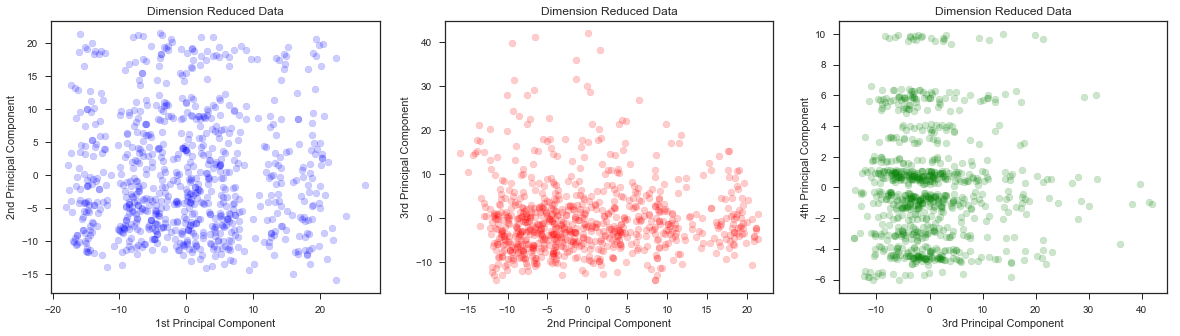

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].scatter(X_non_test_pca[:, 0], X_non_test_pca[:, 1], color='blue', alpha=0.2, label='train R^2')

ax[0].set_title('Dimension Reduced Data')
ax[0].set_xlabel('1st Principal Component')
ax[0].set_ylabel('2nd Principal Component')

ax[1].scatter(X_non_test_pca[:, 1], X_non_test_pca[:, 2], color='red', alpha=0.2, label='train R^2')

ax[1].set_title('Dimension Reduced Data')
ax[1].set_xlabel('2nd Principal Component')
ax[1].set_ylabel('3rd Principal Component')

ax[2].scatter(X_non_test_pca[:, 2], X_non_test_pca[:, 3], color='green', alpha=0.2, label='train R^2')

ax[2].set_title('Dimension Reduced Data')
ax[2].set_xlabel('3rd Principal Component')
ax[2].set_ylabel('4th Principal Component')

plt.show()

In [14]:
print('first pca component:', pca.components_[0])
print('\nsecond pca component:', pca.components_[1])
print('\nthird pca component:', pca.components_[2])
print('\nfourth pca component:', pca.components_[3])

first pca component: [  1.88820519e-01  -5.26484763e-03   4.26631285e-02   8.26497056e-01
   5.24855709e-01  -4.33707343e-02  -4.20355348e-02   2.65481684e-04
   2.52440919e-04   0.00000000e+00   0.00000000e+00  -1.67305530e-02]

second pca component: [ -1.47576401e-01  -3.75177542e-03  -2.71867170e-02  -1.75704431e-02
  -3.08697834e-02  -6.92247888e-01  -7.04968054e-01   6.97884869e-04
   1.20294452e-04   0.00000000e+00   0.00000000e+00  -4.33027759e-03]

third pca component: [  9.42933932e-01  -6.31616094e-03   2.25551732e-01  -1.64758675e-01
  -1.14282888e-01  -9.70939376e-02  -1.01614511e-01  -2.28267695e-04
  -5.81706932e-04  -0.00000000e+00  -0.00000000e+00   1.72933961e-03]

fourth pca component: [ -1.18823574e-02  -3.08203403e-03   2.64935869e-02   5.36754288e-01
  -8.42230173e-01   4.71496951e-03   2.05708008e-02  -3.29704784e-04
  -9.86915072e-04  -0.00000000e+00   0.00000000e+00  -3.52717769e-02]


In [15]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_non_test_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.43586209156624744


Didn't actually improve test R^2 that much, but only started w/12 predictors. So add dimensionality w/polynomial and interaction terms.

### 3. Principal Component Regression With Polynomial and Interaction Terms

In [16]:
gen_poly_terms = PolynomialFeatures(degree=6, interaction_only=False)

min_max_scaler = MinMaxScaler()
X_non_test = min_max_scaler.fit_transform(X_non_test)
X_test = min_max_scaler.fit_transform(X_test)

X_train_full_poly = gen_poly_terms.fit_transform(X_non_test)
X_test_full_poly = gen_poly_terms.fit_transform(X_test)

print('number of total predictors', X_train_full_poly.shape[1])

number of total predictors 18564


In [17]:
pca = PCA(n_components=15)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.35552227  0.22769362  0.1290905   0.05711028  0.03410909  0.0266616
  0.02549993  0.02045665  0.01711273  0.01250721  0.01170766  0.00765672
  0.00750229  0.00562449  0.00528681]


In [18]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.6577157395229831


In [19]:
pca = PCA(n_components=45)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.35552227  0.22769362  0.1290905   0.05711028  0.03410909  0.0266616
  0.02549993  0.02045665  0.01711273  0.01250721  0.01170766  0.00765672
  0.00750229  0.00562449  0.00528682  0.00476528  0.00434796  0.0039612
  0.00350014  0.00300672  0.00280341  0.00255229  0.00232536  0.00211019
  0.00202912  0.00155184  0.00149238  0.00138424  0.00127729  0.00123097
  0.00115086  0.00102756  0.00098427  0.00090609  0.00080083  0.00076304
  0.00071784  0.00064569  0.0005927   0.00053517  0.00047263  0.00046646
  0.00043846  0.00042395  0.00041147]


In [20]:
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)

print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Test R^2: 0.8508000426718758


---

## Selecting the Components of PCA Using Cross Validation

In [21]:
regression_model = LinearRegression(fit_intercept=True)
kf = KFold(n_splits=5) # 5 splits

x_val_scores = []

for n in range(1, 80, 5):
    out = n * 1. / 80 * 100
    sys.stdout.write("\r%d%%" % out)
    sys.stdout.flush()
    
    pca = PCA(n_components=15)
    pca.fit(X_train_full_poly)
    
    validation_R_sqs = []
    for train_index, val_index in kf.split(X_train_pca):
        X_train, X_val = X_train_full_poly[train_index], X_train_full_poly[val_index]
        y_train, y_val = y_non_test[train_index], y_non_test[val_index]

        X_train_pca = pca.transform(X_train)
        X_val_pca = pca.transform(X_val)
        
        regression_model.fit(X_train_pca, y_train)
        validation_R_sqs.append(regression_model.score(X_val_pca, y_val))
        
    x_val_scores.append(np.mean(validation_R_sqs))
    
sys.stdout.write("\r%d%%" % 100)

100%

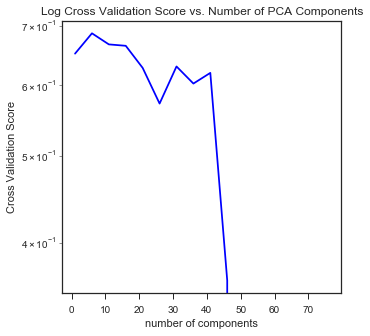

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.plot(range(1, 80, 5), x_val_scores, color='blue')

ax.set_title('Log Cross Validation Score vs. Number of PCA Components')
ax.set_xlabel('number of components')
ax.set_ylabel('Cross Validation Score')
ax.set_yscale('log')

plt.show()

In [23]:
best_n = range(1, 80, 5)[np.argmax(x_val_scores)]

pca = PCA(n_components=best_n)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)

regression_model.fit(X_train_pca, y_non_test)
test_R_sq = regression_model.score(X_test_pca, y_test)

print('best regularization param is:', best_n)
print('the test R^2 for PC regression with n = {} is: {}'.format(best_n, test_R_sq))

best regularization param is: 6
the test R^2 for PC regression with n = 6 is: 0.5320031988707268


because we didn't try to standardize Xs, lots of problems?